In [1]:
%cd ../..

E:\PhD_final_backup_biowulf\new\MDTerp


In [2]:
# MDTerp step 1: Load alanine dipeptide in vacuum simulation trajectory (φ, ψ, θ, ω) and convert into sine/cosines since the VAMPNets model was trained using these 8 features

import numpy as np
import os

root_dir = './docs/examples/'
os.makedirs(root_dir, exist_ok = True)
result_dir = root_dir + 'results/'

aladip_all = np.load(root_dir + 'aladip_unbiased_trajectory.npy')
aladip_all_sin_cos = np.zeros((aladip_all.shape[0], 8))
for i in range(4):
  aladip_all_sin_cos[:, 2*i] = np.sin(aladip_all[:,i])
  aladip_all_sin_cos[:, 2*i+1] = np.cos(aladip_all[:,i])

In [3]:
# MDTerp step 2: Create feature dictionary

sin_cos_dict = {}
sin_cos_dict["φ"] = [0, 1]
sin_cos_dict["ψ"] = [2, 3]
sin_cos_dict["θ"] = [4, 5]
sin_cos_dict["ω"] = [6, 7]

In [4]:
# MDTerp step 3: Import MDTerp.base and implement MDTerp using base.run(). Two required arguments are the dataset and the location of a Python function that loads a black-box model. Go to https://github.com/shams-mehdi/MDTerp/tree/main/examples to check how this Python file should be like.

import MDTerp.base as base


model_function_loc = root_dir + 'MDTerp_VAMPNets_model.txt'
base.run(aladip_all_sin_cos, model_function_loc, save_dir = result_dir, sin_cos_dict = sin_cos_dict , point_max = 100, prob_threshold = 0.4, num_samples = 10000)

10-14-25 17:36:39 initialization  INFO     ----------------------------------------------------------------------------------------------------
10-14-25 17:36:39 initialization  INFO     Starting MDTerp...
10-14-25 17:36:39 initialization  INFO     ----------------------------------------------------------------------------------------------------
10-14-25 17:36:39 initialization  INFO     MDTerp result location >>> ./docs/examples/results/
10-14-25 17:36:39 initialization  INFO     Defined numeric features >>> 0
10-14-25 17:36:39 initialization  INFO     Defined angle features >>> 0
10-14-25 17:36:39 initialization  INFO     Defined sin_cos features >>> 4
10-14-25 17:36:39 initialization  INFO     Number of samples in blackbox model training data >>> 2000000
10-14-25 17:36:39 initialization  INFO     Number of columns in blackbox model training data >>> 8
10-14-25 17:36:39 initialization  INFO     ----------------------------------------------------------------------------------------

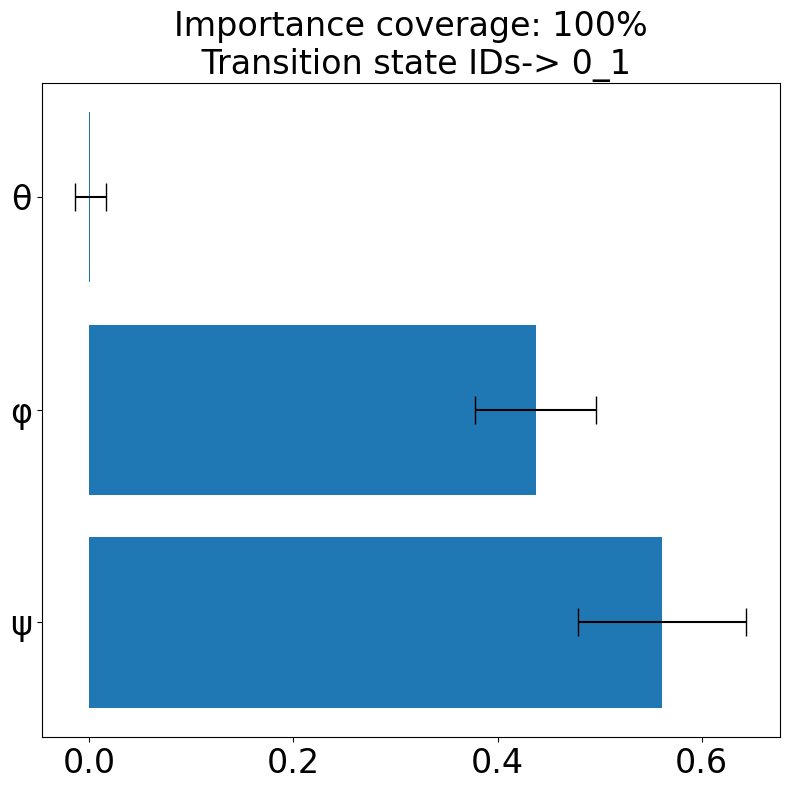

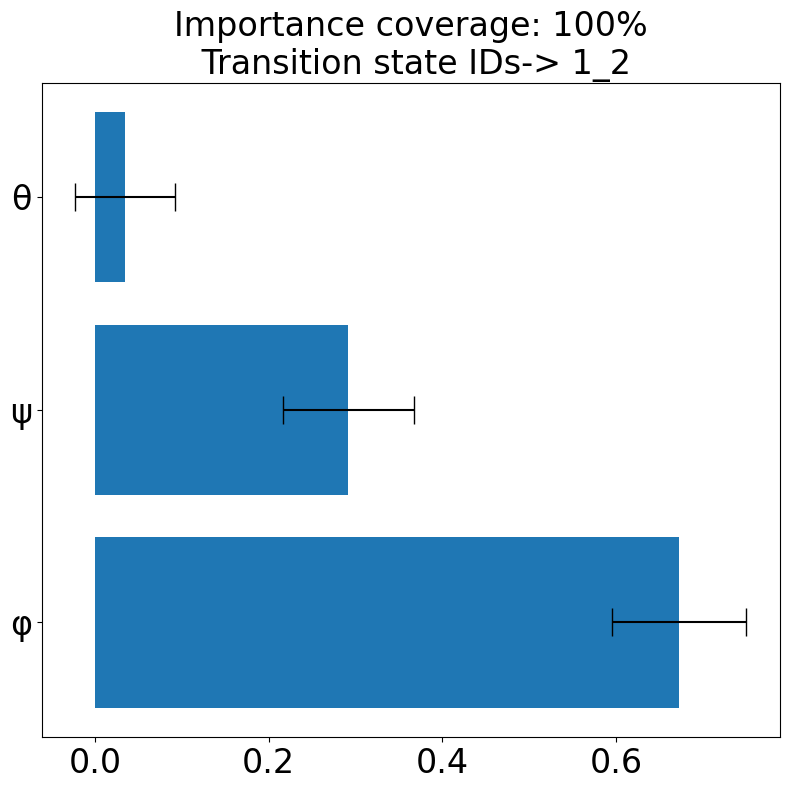

In [6]:
# MDTerp step 3: Summarize feature importance for each of the transition states.
import matplotlib.pyplot as plt
from MDTerp.utils import transition_summary

feature_names_loc = result_dir + 'MDTerp_feature_names.npy'
feature_names = np.load(feature_names_loc)
all_result_loc = result_dir + 'MDTerp_results_all.pkl'

# summary is a dictionary with individual keys for each class transition in the dataset. Each key has the mean and standard deviation of feature importance for all explanations generated for that transition
summary = transition_summary(all_result_loc, importance_coverage = 1.00)

# Loop over all the transitions
for ii in summary:
    ordered_nonzero_indices = np.argsort(summary[ii][0])[::-1][:np.nonzero(summary[ii][0])[0].shape[0]]
    
    ordered_mean = summary[ii][0][ordered_nonzero_indices]
    ordered_std = summary[ii][1][ordered_nonzero_indices]
    
    fig, ax = plt.subplots(figsize = (8,8))
    ax.barh(np.arange(ordered_mean.shape[0]), ordered_mean, xerr = ordered_std, capsize = 10)
    ax.set_title('Importance coverage: ' + str(int(100*np.sum(ordered_mean))) + '%' + '\n Transition state IDs-> ' + ii, fontsize = 24)
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.set_yticks(np.arange(ordered_nonzero_indices.shape[0]))
    ax.set_yticklabels(np.array(feature_names)[ordered_nonzero_indices])
    fig.tight_layout()